# NLP using Neural Networks

This project applies state of the art machine learning technique, Neural Networks to create a multi class text classifier. The dataset contains 13 million board games reviews from different users all around the word. Yes the data set is very large and training this large dataset might be a problem .However , thanks to google , not only for tensorflow but they have a very powerful cloud notebook , which uses GPUs and TPUs and can be used to run Machine learning models for free.

colab by google :- https://colab.research.google.com/notebooks/intro.ipynb#recent=true

#### Why Neural networks ?

The reason I choose neural networks for this project because of two major reasons. Firstly , I have never done NLP using neural networks and I wanted to go out of my way to do something that is neither taught to me any class nor I have had experience with before . Secondly, I have heard all the hype regarding how powerfull neural Networks are and what is the better way of exploring this.




## Review predictor

This project is trained and tested using a large dataset of 13 million boardgames reviews. The model that is created is used to deploy a realtime predictor on a website.

## Importing libraries

First step is to import all the libraries that are needed for this project . Some the libraries I have used are :-
1. Tensorflow and Keras : For creating and testing neural networks models. 
2. sklearn: For splitting the data.
3. matplotlib: For data visualisation.
4. nltk : For cleaning the data using stopwords.
5. re: For creating regular expressions.
6. Numpy: For mathematical operations.
7. Pandas: For reading the data.

In [1]:
# Keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten, Input, Reshape, Concatenate,Conv2D,MaxPool2D,concatenate ,Dropout
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l1,l2,l1_l2
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
## Plot
import  matplotlib.pyplot as plt
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# Other
import re
import string
import numpy as np
import pandas as pd
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploring the data

In order to process the data we first need to explore it , understand it , find patterns and finally then we can process the data to our model.
I am using pandas to read the CSV file and to apply certain operations on it. Pandas offer a fast yet equally powerfull data processing library.

### 1. Reading the data

In [0]:
reviews = pd.read_csv("/content/drive/My Drive/reviews.csv", error_bad_lines=False)

### 2. Displaying the data

In [4]:
reviews.head()

,Unnamed: 0,rating,comment
0,0,10.0,NaN
1,1,10.0,NaN
2,2,10.0,"Currently, this sits on my list as my favorite..."
3,3,10.0,"I know it says how many plays, but many, many ..."
4,4,10.0,NaN


### 3. Data statistics

In [5]:
reviews.describe()

,Unnamed: 0,rating
count,1.317007e+07,1.317007e+07
mean,6.585036e+06,7.023914e+00
std,3.801873e+06,1.602762e+00
min,0.000000e+00,1.401300e-45
25%,3.292518e+06,6.000000e+00
50%,6.585036e+06,7.000000e+00
75%,9.877554e+06,8.000000e+00
max,1.317007e+07,1.000000e+01


### 4. Finding Null comments

In [6]:
print(reviews[reviews['comment'].isna()])

          Unnamed: 0  rating comment
0                  0    10.0     NaN
1                  1    10.0     NaN
4                  4    10.0     NaN
5                  5    10.0     NaN
6                  6    10.0     NaN
...              ...     ...     ...
13170060    13170060     4.0     NaN
13170061    13170061     4.0     NaN
13170064    13170064     3.0     NaN
13170068    13170068     3.0     NaN
13170072    13170072     2.0     NaN

[10532317 rows x 3 columns]


### 5. Numer of different ratings

In [7]:
print(reviews['rating'].value_counts())

7.00000    2977370
8.00000    2468632
6.00000    1987008
9.00000    1158917
5.00000     923398
            ...   
5.26900          1
6.77960          1
7.08912          1
5.48100          1
6.79767          1
Name: rating, Length: 8202, dtype: int64


### 6. Visualising the ratings vs count

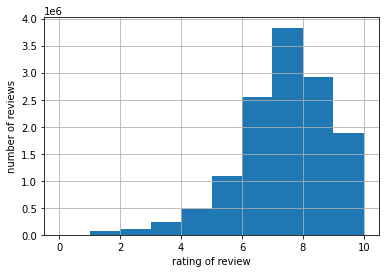

In [8]:

reviews.head()
reviews['rating'].hist(bins=10)
plt.xlabel('rating of review')
plt.ylabel('number of reviews')
plt.show()

## Data Cleaning

After visualising the data we can conlude the following things:-
1. The data is unbalanced. Some ratings have more data than others. Like rating 1 Has least data while 7 has the most data.
2. The data has null values.
3. Text data always have some errors and needs to be cleaned before processing.
4. The ratings sections has 8202 classes.


### Removing Null values
Using the pandas inbuilt function I am removing all the rows with null values.

In [9]:
reviews= reviews.dropna()
reviews.head()

,Unnamed: 0,rating,comment
2,2,10.0,"Currently, this sits on my list as my favorite..."
3,3,10.0,"I know it says how many plays, but many, many ..."
7,7,10.0,i will never tire of this game.. Awesome
11,11,10.0,This is probably the best game I ever played. ...
16,16,10.0,Fantastic game. Got me hooked on games all ove...


### Reducing the number of classes for ratings

I am using numpy round function to convert the double rating to corresponding integer values . This is will reduce the number of classes to 10. 

In [10]:
reviews['rating'] = np.around(reviews['rating'])
reviews['rating'].replace(0.0,1.0, inplace=True)
print(reviews['rating'].value_counts())

8.0     657581
7.0     574586
6.0     526481
9.0     239410
5.0     217766
10.0    153530
4.0     136565
3.0      70974
2.0      40766
1.0      20097
Name: rating, dtype: int64


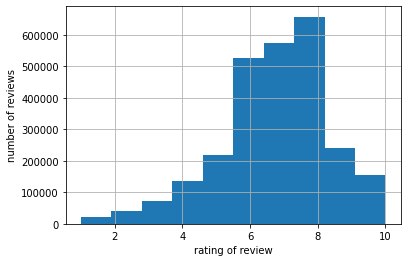

In [11]:
reviews.head()
reviews['rating'].hist(bins=10)
plt.xlabel('rating of review')
plt.ylabel('number of reviews')
plt.show()

### Balancing the data

The data is still unbalanced as we can see that we have more data for rating of 7 and 8 . So to feed the neural network we need to balance the data . I am using pandas to extract frames of individual ratings from the data and then sampling them to a single value so that all the ratings have equal number of data. Finally I use concatenate to add all data into a new data frame.

In [0]:
sam = 20000

reviews_rate_1 = reviews[reviews['rating']  == 1.0]
reviews_rate_2 = reviews[reviews['rating']  == 2.0]
reviews_rate_3 = reviews[reviews['rating']  == 3.0]
reviews_rate_4 = reviews[reviews['rating']  == 4.0]
reviews_rate_5 = reviews[reviews['rating']  == 5.0]
reviews_rate_6 = reviews[reviews['rating']  == 6.0]
reviews_rate_7 = reviews[reviews['rating']  == 7.0]
reviews_rate_8 = reviews[reviews['rating']  == 8.0]
reviews_rate_9 = reviews[reviews['rating']  == 9.0]
reviews_rate_10 = reviews[reviews['rating']  == 10.0]


In [0]:

reviews_rate_1 = reviews_rate_1.sample(sam)
reviews_rate_2 = reviews_rate_2.sample(sam)
reviews_rate_3 = reviews_rate_3.sample(sam)
reviews_rate_4 = reviews_rate_4.sample(sam)
reviews_rate_5 = reviews_rate_5.sample(sam)
reviews_rate_6 = reviews_rate_6.sample(sam)
reviews_rate_7 = reviews_rate_7.sample(sam)
reviews_rate_8 = reviews_rate_8.sample(sam)
reviews_rate_9 = reviews_rate_9.sample(sam)
reviews_rate_10 = reviews_rate_10.sample(sam)
reviews_balanced = pd.concat([reviews_rate_1,reviews_rate_2,reviews_rate_3,
                              reviews_rate_4,reviews_rate_5,reviews_rate_6,reviews_rate_7,
                              reviews_rate_8,reviews_rate_9,reviews_rate_10],axis=0)

In [14]:
reviews_balanced.head()

,Unnamed: 0,rating,comment
13074175,13074175,1.0,This is not a game. This is not a toy. It is...
11596409,11596409,1.0,Not very interesting.
6410177,6410177,1.0,"Awful game, bad balancing"
13040006,13040006,1.0,This is an old Hungarian version of Monopoly t...
12662505,12662505,1.0,"Truly awful game, I can't imagine what Avalon ..."


In [15]:
print(reviews_balanced['rating'].value_counts())

7.0     20000
8.0     20000
5.0     20000
6.0     20000
4.0     20000
9.0     20000
3.0     20000
10.0    20000
2.0     20000
1.0     20000
Name: rating, dtype: int64


### Cleaning the data

This is one of the more important past of text preprocessing . Since everybody has a different writing style we need to make sure that data is error free and consistent. The first things is make sure that the data is lowercase so that our model doesnot consider 'Hello' and 'hello' as two different features. Then we use NLTK library to download all the english stopwords and remove them from my data. Stopwords include is , the etc which have know meaning in determining the rating of the review so we remove them. Finally , we clean all the contractions , punctutions and abbreviations from the data using regular expressions.

In [0]:
def clean_text(text):
    text = text.lower().split()
    
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

In [0]:
reviews_balanced['comment'] = reviews_balanced['comment'].map(lambda text : clean_text(text))

In [19]:
reviews_balanced.head()

,Unnamed: 0,rating,comment
13074175,13074175,1.0,game toy inconceivable anyone thought could se...
11596409,11596409,1.0,interesting
6410177,6410177,1.0,awful game bad balancing
13040006,13040006,1.0,old hungarian version monopoly board streets b...
12662505,12662505,1.0,truly awful game ca not imagine avalon hill th...


## Data Preprocessing 


### Review length 

First we need to find out what is the length of reviews in our data set . This is important beacause we need to tokenize our data and we need to define certain hyperparameters for our model. This will all be possible and more optimised if we fully understand the data. I am using pandas to calculate the number of words for each comment , then we create 5 word bins based on the number of words each of these comments have. Finally I display the number of comments we have in each of the bin.

In [0]:
reviews_balanced['num_words'] = reviews_balanced.comment.apply(lambda x : len(x.split()))
reviews_balanced['bins']=pd.cut(reviews_balanced.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])
word_distribution = reviews_balanced.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [21]:
word_distribution.head()

,bins,counts
0,0-100,191519
1,100-300,5319
2,300-500,368
3,500-800,81
4,>800,27


We can see that majority of our comments have a word count between 0-100 . 

### Dividing the data

We need to divide the data into testing and training data. For this I am using train_test_split() function by sklearn . This divides the data randomly by into the ratio provided by the user as a paramter. Here i haves used '0.3' , So I got a 70:30 ratio of train and test data.

In [0]:
x_train ,x_test, y_train, y_test = train_test_split(reviews_balanced.comment, reviews_balanced['rating'], test_size=0.3)


In [23]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(140000,)
(60000,)
(140000,)
(60000,)


### Tokenization and BOW Vocabulary

Before the data can be fed into neural network model , we need to make tokenize the data . Tokenization is the process of converting the data into numbers , since a computer can only understand numbers. Tokenization works by creating a dictionary of the most used words in a sentence then replacing the word by its corresponding index.

Suppose we have : 

"Hello this is rohan " - THIS IS NOT UNDERSTANDABLE BY A MACHINE

We tokenize it by creating a dictionary : 

{ Hello : 1 , this : 2 , is : 3 , Rohan : 4 }

Then we replace the word by its corresponding index. So now our sentence becomes : 

[1 , 2, 3, 4] - THIS IS UNDERSTANDABLE BY A MACHINE

In [0]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower = True,oov_token='OOV')
tokenizer.fit_on_texts([list(x_train),list(x_test)])
x_train_1 = tokenizer.texts_to_sequences(x_train)
x_test_1 = tokenizer.texts_to_sequences(x_test)


I used keras tokenizer() function to create a BOW . I haves specified max_features which will extract top 10000 words from the corpus. Filters argument will not consider all the symbols as features , since they have no significanc over the ratings and oov_token is used to represent out of vocabulary words.Then I am using both test and train data to create this BOW using fit_on_texts() function. Finally I am converting the the sentences to machine readable vectors using text_to_sequences() function.

In [0]:
### Padding and Tensors

Since we are using tensorflow we need to create the input tensors . This is very simple but we know that the length of our text sequences are different. A NN takes in input of the input size provided during model compilation , so we need to make sure that all of our tensors are of equal length. 

This is were we use padding. Padding means adding zeros either at the begining or at the end of the text sequences. The number of zeroes depend upon the how many zeros are need to make all the sequence of equal length. I am using keras pad_sequences function. We need to specifiy the maximum length of the sequence . As we know most of our data is < 100 words I am using max_len of 100. To save training time and memory.

In [0]:
max_len = 100
x_train_1 = pad_sequences(x_train_1,max_len, padding = "post")
x_test_1 = pad_sequences(x_test_1,max_len, padding = "post")

In [26]:
print(x_train_1[1])

[614   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


The result of padding gives a tensor of 100 length.The zeros were added in the end since i specified padding as 'Post'.

### Vocabulary

The tokenizer function creates a dictionary of words which is our vocabulary.

In [27]:
tokenizer.word_index

{'OOV': 1,
 '': 2,
 ' ': 3,
 'kickstarter': 4,
 'played': 5,
 'players': 6,
 'game ': 7,
 'meh ': 8,
 'kids': 9,
 'boring ': 10,
 'sleeved': 11,
 'pnp': 12,
 'sold': 13,
 'game': 14,
 'smjj loves game therefore hate': 15,
 'meh': 16,
 'boring': 17,
 'reviewed blog ': 18,
 '2 - 4': 19,
 'plays': 20,
 'play': 21,
 'i am interested type experience via board game medium consider board game ': 22,
 '2 - 4 players': 23,
 ' : thumbsdown : communcal cards : thumbsdown : strategically shallow : thumbsdown : tediously tactical': 24,
 'ios': 25,
 'kickstarted': 26,
 'great game': 27,
 'fun': 28,
 'good game': 29,
 'sell': 30,
 ' url = http : fortressat com articles - analysis 2767 - idiots i play url ': 31,
 'p p': 32,
 'best': 33,
 'need try': 34,
 '2 - 5': 35,
 'classic': 36,
 ' ! ': 37,
 'brazil brazilian publisher redbox positioned conservative candidate may contribute communist candidate winning elections ': 38,
 'no ': 39,
 'good game ': 40,
 'see www brettspillguiden no norwegian only sorr

In [28]:
vocab_size = len(tokenizer.word_index) + 1
print("The size of our vocaulary is ",vocab_size)

The size of our vocaulary is  187628


### Preparing classification labels

Since our classifiction is a multi class classification we need to find the unqiue labels and convert them to categorical tensor so that our NN model can understand it. I am using skleans label encoder to conver the data into categorical tensors.

In [29]:
(unique, counts) = np.unique(y_train, return_counts=True)
num_classes = len(counts)
print(unique)
print(num_classes)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
10


I have 10 classes. Now i need to convert this numerical data into categorical tensors. A categorical tensors are binary tensor with columns equal to num of classes. 

For our case we have 10 classes so for a label with value 8 will be equal to:

[0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0]

In [31]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)
print(y_train.shape)
print(to_categorical(y_train)[1])
print(to_categorical(y_train).shape)

(140000,)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(140000, 10)


In [0]:
I have used encoder to convert my train data into categorical tensor. As we can see before the data was of 1 dim now it is 2 dim . The 10 colums signify which class the data belong to. 

## Neural Network Model

Now comes the brain our of classifier , the neural network model. There are many neural network architectures but for this project I am going to use a shallow NN , a Deep NN , a CNN and a CNN with regularization. 

For all my models i am going to use 'softmax' activation function for output layer . Why softmax you ask , because we are doing multi class classification . Softmax function gives probabilites for all the classes and the one with the maximum probabilty is our preditiction . 

For loss we are going to use 'keras.loss.categorical_crossentropy' since it is a softmax loss function which is used for multi class prediction.

For optimizer I am going to use 'keras.optimizer.adam'. Adam is one of the fastest and accurate optimizer for classification.

## Shallow NN 

Here I have 2 dense keras.layers in a functional model.The first layer will be  input layer to get the input and pass it to the other layers. For text classification we need to have an embedding layer . An embedding layer initializes random weights for all the words and will learn embedding for all the words. we need to set the size the of embedding matrix , here i will be using 50. This size is used represent the embedding of the words. The total trainable paramaters are 50 * max_features. Then I add a flatten layer to convert the 2 dim ouput of embedding layer to 1 dim . Finally I use 2 dense layers or fully connected layers to train and get my prediction. 

number of nodes for dense layer1 = 512
number of nodes for dense layer2 or prediction = Num of classes

The activation function that I am using for input layer is Relu . Relu is Rectified Linear Unit.The function returns 0 if it receives any negative input, but for any positive value  x it returns that value back. So it can be written as  f(x)=max(0,x).
 

In [32]:
Inputs = Input(shape=(max_len, ))
embedding_layer = Embedding(max_features,50, input_length=max_len)(Inputs)
x = Flatten()(embedding_layer)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs=[Inputs], outputs=predictions)
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2560512   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 3,065,642
Trainable params: 3,065,642
Non-trainable params: 0
_________________________________________________________________


## Deep NN 

Here I have 4 dense keras.layers in a functional model. The model is similar to the above model but the number of dense layers I used increased . This makes the networks a deep NN as the number of hidden layers are more. The nodes in each layer are  128,100, 32 and num_classes.
 

In [33]:
Inputs = Input(shape=(max_len, ))
embedding_layer = Embedding(max_features,50, input_length=max_len)(Inputs)
x = Flatten()(embedding_layer)
x = Dense(128, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model2 = Model(inputs=[Inputs], outputs=predictions)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               640128    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330 

## Deep CNN without regularization

I am using a functional model to create a network with 1 embedding layer, 2 conv2D layers and 1 dense layer. The filters I used for convolutional layers are 2 and 3 and num of filters i used is 50.

In [0]:
embedding_d = 50 
filter_sizes = [2,3]
Num_f = 16

In [35]:
Inputs = Input(shape=(max_len,))
x = Embedding(max_features, embedding_d)(Inputs)
x = Reshape((max_len, embedding_d, 1))(x)
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv2D(Num_f, kernel_size=(filter_sizes[i], embedding_d),
                                     kernel_initializer='he_normal', activation='relu')(x)
    maxpool_pool.append(MaxPool2D(pool_size=(max_len - filter_sizes[i] + 1, 1))(conv))
x = Concatenate(axis=1)(maxpool_pool)   
x = Flatten()(x)
x = Dropout(0.1)(x)
predictions = Dense(10, activation="softmax")(x)
model3 = Model(inputs=[Inputs], outputs=predictions)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 50)      500000      input_3[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 50, 1)   0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 1, 16)    1616        reshape_1[0][0]                  
____________________________________________________________________________________________

## Deep CNN with regularization

I am using a functional model to create a network with 1 embedding layer, 2 conv2D layers and 1 dense layer. The filters I used for convolutional layers are 2 and 3 and num of filters i used is 50. Here i am using l1 regularization to improve the accuracy.

In [51]:
embedding_d = 100 
filter_sizes = [2,3]
Num_f = 64

Inputs = Input(shape=(max_len,))
x = Embedding(max_features, embedding_d)(Inputs)
x = Reshape((max_len, embedding_d, 1))(x)
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv2D(Num_f, kernel_size=(filter_sizes[i], embedding_d), activation='relu',kernel_regularizer = l1(0.0001))(x)
    maxpool_pool.append(MaxPool2D(pool_size=(max_len - filter_sizes[i] + 1, 1))(conv))
x = Concatenate(axis=1)(maxpool_pool)   
x = Flatten()(x)
x = Dropout(0.1)(x)
predictions = Dense(10, activation="softmax")(x)
model4 = Model(inputs=[Inputs], outputs=predictions)
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 100, 100)     1000000     input_6[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 100, 100, 1)  0           embedding_6[0][0]                
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 99, 1, 64)    12864       reshape_4[0][0]                  
____________________________________________________________________________________________

## Training all the models

Here I am training all my models using the training data. I am using callback to make sure that the best accurcay is recorded.

In [37]:
filepath="model1.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history1 = model1.fit(x_train_1, to_categorical(y_train), batch_size = 16, epochs = 4, validation_split = .1,callbacks=[checkpointer])


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 126000 samples, validate on 14000 samples
Epoch 1/4
126000/126000 [==============================] - 81s 641us/step - loss: 2.0908 - accuracy: 0.1995 - val_loss: 2.0661 - val_accuracy: 0.2076
Epoch 2/4
   304/126000 [..............................] - ETA: 1:19 - loss: 1.9921 - accuracy: 0.2368

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


126000/126000 [==============================] - 78s 623us/step - loss: 2.0281 - accuracy: 0.2267 - val_loss: 2.0598 - val_accuracy: 0.2116
Epoch 3/4
126000/126000 [==============================] - 78s 620us/step - loss: 1.9310 - accuracy: 0.2690 - val_loss: 2.1113 - val_accuracy: 0.2080
Epoch 4/4
126000/126000 [==============================] - 77s 609us/step - loss: 1.7550 - accuracy: 0.3469 - val_loss: 2.2744 - val_accuracy: 0.1991


In [38]:
filepath="model2.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history2 = model2.fit(x_train_1, to_categorical(y_train), batch_size = 16, epochs = 4, validation_split = .1,callbacks=[checkpointer])



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 126000 samples, validate on 14000 samples
Epoch 1/4
126000/126000 [==============================] - 50s 394us/step - loss: 2.0976 - accuracy: 0.1946 - val_loss: 2.0711 - val_accuracy: 0.2134
Epoch 2/4
   448/126000 [..............................] - ETA: 48s - loss: 1.9714 - accuracy: 0.2500

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


126000/126000 [==============================] - 48s 379us/step - loss: 2.0377 - accuracy: 0.2191 - val_loss: 2.0573 - val_accuracy: 0.2086
Epoch 3/4
126000/126000 [==============================] - 48s 380us/step - loss: 2.0013 - accuracy: 0.2309 - val_loss: 2.0686 - val_accuracy: 0.2106
Epoch 4/4
126000/126000 [==============================] - 49s 387us/step - loss: 1.9466 - accuracy: 0.2505 - val_loss: 2.0999 - val_accuracy: 0.2067


In [39]:
filepath="model3.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history3 = model3.fit(x_train_1, to_categorical(y_train), batch_size = 16, epochs = 4, validation_split = .1,callbacks=[checkpointer])


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 126000 samples, validate on 14000 samples
Epoch 1/4
126000/126000 [==============================] - 51s 406us/step - loss: 2.0974 - accuracy: 0.2026 - val_loss: 2.0600 - val_accuracy: 0.2140
Epoch 2/4
   400/126000 [..............................] - ETA: 52s - loss: 2.0776 - accuracy: 0.1900

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


126000/126000 [==============================] - 51s 405us/step - loss: 2.0540 - accuracy: 0.2173 - val_loss: 2.0469 - val_accuracy: 0.2186
Epoch 3/4
126000/126000 [==============================] - 53s 417us/step - loss: 2.0433 - accuracy: 0.2205 - val_loss: 2.0448 - val_accuracy: 0.2205
Epoch 4/4
126000/126000 [==============================] - 51s 403us/step - loss: 2.0369 - accuracy: 0.2226 - val_loss: 2.0462 - val_accuracy: 0.2187


In [53]:
filepath="model4.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history4 = model4.fit(x_train_1[1:10000], to_categorical(y_train[1:10000]), batch_size = 16, epochs = 4, validation_split = .1,callbacks=[checkpointer])


Train on 8999 samples, validate on 1000 samples
Epoch 1/4
8999/8999 [==============================] - 6s 688us/step - loss: 2.0670 - accuracy: 0.2211 - val_loss: 2.0824 - val_accuracy: 0.2140
Epoch 2/4
 256/8999 [..............................] - ETA: 6s - loss: 2.0530 - accuracy: 0.2422

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8999/8999 [==============================] - 7s 726us/step - loss: 2.0502 - accuracy: 0.2282 - val_loss: 2.0947 - val_accuracy: 0.2310
Epoch 3/4
8999/8999 [==============================] - 6s 622us/step - loss: 2.0366 - accuracy: 0.2336 - val_loss: 2.1071 - val_accuracy: 0.2230
Epoch 4/4
8999/8999 [==============================] - 5s 601us/step - loss: 2.0209 - accuracy: 0.2360 - val_loss: 2.1062 - val_accuracy: 0.2180


## Evaluating The model

Here i am using sklearn model evaluate to test the accurcay of our model. 

In [45]:
score1 = model1.evaluate(x_test_1, to_categorical(y_test), verbose=1)
print(score1)

60000/60000 [==============================] - 3s 52us/step
[2.29589410832723, 0.1970333307981491]


In [46]:
score2 = model2.evaluate(x_test_1, to_categorical(y_test), verbose=1)
print(score2)

60000/60000 [==============================] - 2s 36us/step
[2.098565194129944, 0.21246667206287384]


In [47]:
score3 = model3.evaluate(x_test_1, to_categorical(y_test), verbose=1)
print(score3)

60000/60000 [==============================] - 2s 42us/step
[2.0422845794677733, 0.22183333337306976]


In [54]:
score4 = model4.evaluate(x_test_1, to_categorical(y_test), verbose=1)
print(score4)

60000/60000 [==============================] - 4s 59us/step
[2.092603381093343, 0.21591666340827942]


## Saving the model

Here I am saving all the models as h5 files so that i can use them to again without training them. Also I need to save my tokenizer or vocabulary so that any new sentence can be processed before feeding into the NN.

In [0]:
import pickle
odel1.save("/content/drive/My Drive/model1.h5")
model2.save("/content/drive/My Drive/model2.h5")
model3.save("/content/drive/My Drive/model3.h5")
model4.save("/content/drive/My Drive/model4.h5")
with open('/content/drive/My Drive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## visualizing the Results

I am using matplot lib to visualize all my accuracy for the best model . Which is the CNN with regularization.

Text(0.5, 0, 'epoch')

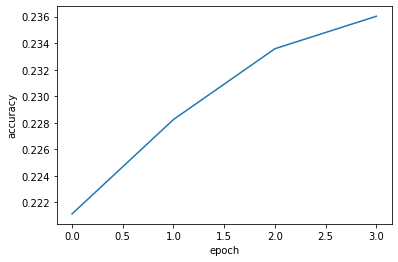

In [74]:
plt.plot(history4.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

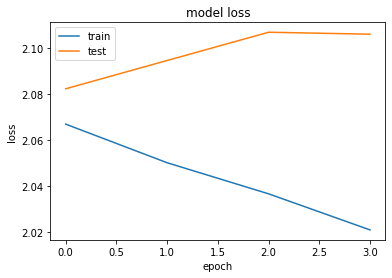

In [73]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Classification report

In [78]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, np.argmax(model4.predict(x_test_1),axis=1)))

              precision    recall  f1-score   support

           0       0.22      0.61      0.32      6021
           1       0.26      0.07      0.12      5968
           2       0.19      0.07      0.10      5946
           3       0.16      0.21      0.18      6001
           4       0.19      0.09      0.13      6036
           5       0.18      0.15      0.16      5966
           6       0.19      0.26      0.22      6019
           7       0.23      0.08      0.12      5990
           8       0.19      0.13      0.15      6035
           9       0.31      0.48      0.38      6018

    accuracy                           0.22     60000
   macro avg       0.21      0.22      0.19     60000
weighted avg       0.21      0.22      0.19     60000



## Conclusion

I would say that my neural network model did not perform well enough as i expected. However CNN works better as compared to dense neural networks. There are better models present like RNN and LSTM but due to the computational power i was not able to implement them.
